# **Fraudulent Transaction Detection**

This is a data science portfolio case proposed in the site [Seja Um Data Scientist](https://sejaumdatascientist.com/crie-uma-solucao-para-fraudes-em-transacoes-financeiras-usando-machine-learning/), the data set used is [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/ealaxi/paysim1).

## **1 - Business Understanding**
### 1.1 - Blocker Fraud Company
The Blocker Fraud Company is specialized in detecting fraudulent transactions made through mobile devices, the service Blocker Fraud ensures the blocking of those transactions. The company's business model is of the Service type, with monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the client's transactions.
### 1.2 - Expansion Strategy
A very agressive strategy:
*   The company will receive 25% of the value of each transaction that is truly detected as fraud.
*   The company will receive 5% of the value of each transaction detected as fraud, however the transaction is truly legitimate.
*   The company will return 100% of the value to the customer for each transaction detected as legitimate, however the transaction is truly a fraud.

### 1.3 - The Challenge
You have been hired as a Data Science Consultant to create a highly accurate fraud detection model. You need to provide a model in production where clients will send their transactions via API to be classified as fraudulent or legitimate. In addition, you need to submit a report containing your model's performance and the profit that the company will make using the service. Your report should contain the answers to the following questions:
*   What is the model's Precision and Accuracy?
*   How Reliable is the model in classifying transactions as legitimate or fraudulent?
*   What is the Expected Revenue by the Company if we classify 100% of transactions with the model?
*   What is the Loss Expected by the Company in case of model failure?
*   What is the Profit Expected by the Blocker Fraud Company when using the model?


In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.6 MB/s 


## **2 - Imports and Functions**


In [2]:
import numpy             as np
import pandas            as pd
import pickle
import os

#visualization
import seaborn           as sns
import matplotlib.pyplot as plt

#models

from sklearn.svm             import SVC
from sklearn.naive_bayes     import GaussianNB
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neural_network  import MLPClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier

#metrics and assistants
from sklearn.metrics         import confusion_matrix, balanced_accuracy_score, precision_score, classification_report, recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from category_encoders       import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
seed = 0
np.random.seed(seed)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    balanced_accuracies_sc = []
    precisions = []
    precisions_sc = []
    recalls = []
    recalls_sc = []
    f1s = []
    f1s_sc = []
    kappas = []
    kappas_sc = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train].values.ravel(), y.iloc[index_test].values.ravel()
        ## minmaxscaler or not
        for n in [1,2]:
          if n == 1:
            ## training the model
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            ## saving the metrics
            balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))
            kappas.append(cohen_kappa_score(y_test, y_pred))
          else:
            ## applying the scale
            x_train = mm.fit_transform(x_train)
            x_test = mm.transform(x_test)

            ## training the model
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            ## saving the metrics
            balanced_accuracies_sc.append(balanced_accuracy_score(y_test, y_pred))
            precisions_sc.append(precision_score(y_test, y_pred))
            recalls_sc.append(recall_score(y_test, y_pred))
            f1s_sc.append(f1_score(y_test, y_pred))
            kappas_sc.append(cohen_kappa_score(y_test, y_pred))
          
        '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    accuracy_mean_sc, accuracy_std_sc = np.round(np.mean(balanced_accuracies_sc), 3), np.round(np.std(balanced_accuracies_sc), 3)
    precision_mean_sc, precision_std_sc = np.round(np.mean(precisions_sc), 3), np.round(np.std(precisions_sc), 3) 
    recall_mean_sc, recall_std_sc = np.round(np.mean(recalls_sc), 3), np.round(np.std(recalls_sc), 3)
    f1_mean_sc, f1_std_sc = np.round(np.mean(f1s_sc), 3), np.round(np.std(f1s_sc), 3)
    kappa_mean_sc, kappa_std_sc = np.round(np.mean(kappas_sc), 3), np.round(np.std(kappas_sc), 3)
    
    model1 = pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])
    model2 = pd.DataFrame({ "Balanced Accuracy": "{} +/- {}".format(accuracy_mean_sc, accuracy_std_sc),
                        "Precision": "{} +/- {}".format(precision_mean_sc, precision_std_sc),
                        "Recall": "{} +/- {}".format(recall_mean_sc, recall_std_sc),
                        "F1": "{} +/- {}".format(f1_mean_sc, f1_std_sc),
                        "Kappa": "{} +/- {}".format(kappa_mean_sc, kappa_std_sc)},
                       index=[model_name+" scaled"])
    finalresult = model1.append(model2)
    return finalresult





## **3 - Data Description**
### 3.1 - Loading Data

In [ ]:
# Reducing the data set size, it has more than 6 million rows, so 600k were randomly selected.
#dataset = pd.read_csv("/content/drive/MyDrive/Projetos_ML/fraud/raw_data.csv")
#dataset = dataset.sample(n=600000, random_state = 24601)
#dataset.to_csv("/content/drive/MyDrive/github/fraud_detection/data/reduced_data.csv",index=False)

In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/github/fraud_detection/data/reduced_data.csv")

In [ ]:
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,156,CASH_IN,95021.34000,C468614750,1498038.93000,1593060.27000,C1150582576,4189433.84000,4094412.50000,0,0
1,284,PAYMENT,17611.16000,C836991056,46468.00000,28856.84000,M1730986156,0.00000,0.00000,0,0
2,375,CASH_OUT,57384.49000,C1263681075,104661.00000,47276.51000,C1048640549,153452.69000,210837.18000,0,0
3,19,PAYMENT,6862.76000,C1270254996,1798.00000,0.00000,M1455085050,0.00000,0.00000,0,0
4,38,CASH_IN,391297.20000,C1999608436,6274191.19000,6665488.40000,C813772791,3173773.91000,2782476.71000,0,0


### 3.2 - Data Description
#### 3.2.1 - Variables

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** -amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Text(0.5, 1.0, 'type in isFraud')

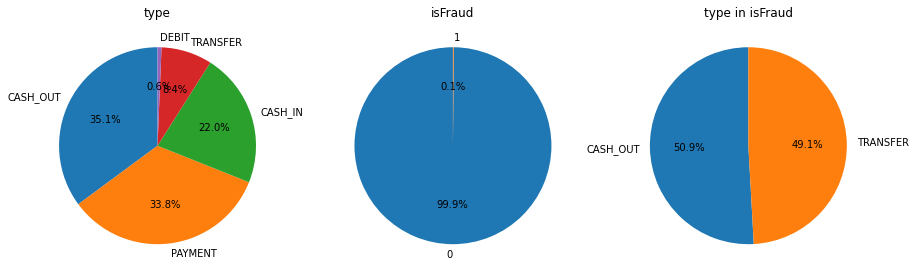

In [ ]:
counts_type = dataset.type.value_counts().to_frame()
counts_type['Percentage'] = counts_type['type']/counts_type['type'].sum()
counts_fraud = dataset.isFraud.value_counts().to_frame()
counts_fraud['Percentage'] = counts_fraud['isFraud']/counts_fraud['isFraud'].sum()

dataset_f = dataset[dataset['isFraud'] == 1]
counts_type_f = dataset_f.type.value_counts().to_frame()
counts_type_f['Percentage'] = counts_type_f['type']/counts_type_f['type'].sum()


fig, ax1 = plt.subplots(1, 3, figsize=(15,5))
ax1[0].pie(counts_type['Percentage'], labels=counts_type.index, autopct='%1.1f%%', startangle=90)
ax1[0].set_title('type')
ax1[1].pie(counts_fraud['Percentage'], labels=counts_fraud.index, autopct='%1.1f%%', startangle=90)
ax1[1].set_title('isFraud')
ax1[2].pie(counts_type_f['Percentage'], labels=counts_type_f.index, autopct='%1.1f%%', startangle=90)
ax1[2].set_title('type in isFraud')

In [ ]:
# selecting only transfer and cash_out transactions

dataset = dataset.loc[(dataset['type'] == "CASH_OUT") | (dataset['type'] == "TRANSFER")]

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260921 entries, 2 to 599998
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            260921 non-null  int64  
 1   type            260921 non-null  object 
 2   amount          260921 non-null  float64
 3   nameOrig        260921 non-null  object 
 4   oldbalanceOrg   260921 non-null  float64
 5   newbalanceOrig  260921 non-null  float64
 6   nameDest        260921 non-null  object 
 7   oldbalanceDest  260921 non-null  float64
 8   newbalanceDest  260921 non-null  float64
 9   isFraud         260921 non-null  int64  
 10  isFlaggedFraud  260921 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 23.9+ MB


In [ ]:
dataset.isna().mean()

step             0.00000
type             0.00000
amount           0.00000
nameOrig         0.00000
oldbalanceOrg    0.00000
newbalanceOrig   0.00000
nameDest         0.00000
oldbalanceDest   0.00000
newbalanceDest   0.00000
isFraud          0.00000
isFlaggedFraud   0.00000
dtype: float64

#### 3.2.2 - Statistics Summary

In [ ]:
dataset['isFraud'] = dataset['isFraud'].astype("object")
dataset['isFlaggedFraud'] = dataset['isFlaggedFraud'].astype("object")


In [ ]:
dataset.describe(exclude= 'object')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,260921.00000,260921.00000,260921.00000,260921.00000,260921.00000,260921.00000
mean,241.89985,319024.10950,47665.32754,16160.67231,1702898.53733,2050760.75224
std,141.87174,936601.32092,258802.44135,157815.65767,4235081.31933,4723136.02123
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,155.00000,83419.04000,0.00000,0.00000,128900.08000,330098.49000
50%,236.00000,171795.28000,303.00000,0.00000,556562.71000,829041.24000
75%,332.00000,307330.29000,31072.00000,0.00000,1745440.47000,2125512.53000
max,742.00000,92445516.64000,59585040.37000,49585040.37000,300985927.86000,301140972.46000


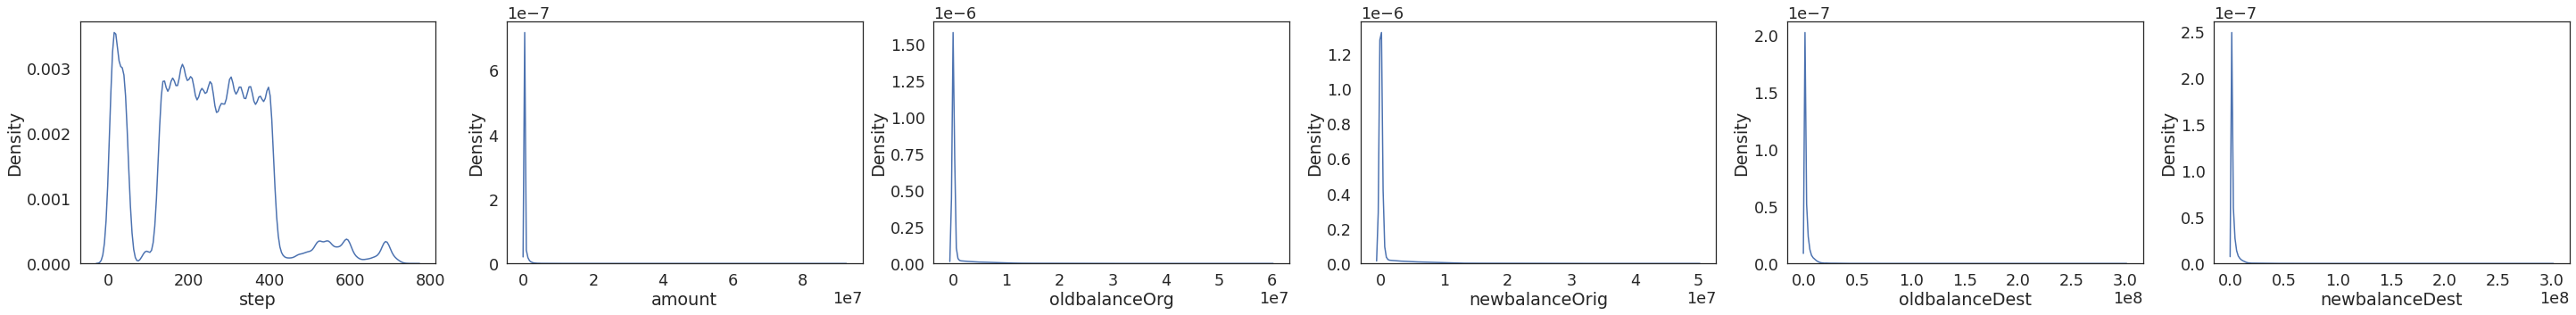

In [20]:
fig, axes = plt.subplots(1, 6, figsize=(50,5))

sns.kdeplot(ax=axes[0], x='step',  data=dataset)
sns.kdeplot(ax=axes[1], x='amount',  data=dataset)
sns.kdeplot(ax=axes[2], x='oldbalanceOrg',  data=dataset)
sns.kdeplot(ax=axes[3], x='newbalanceOrig', data=dataset)
sns.kdeplot(ax=axes[4], x='oldbalanceDest', data=dataset)
sns.kdeplot(ax=axes[5], x='newbalanceDest', data=dataset)

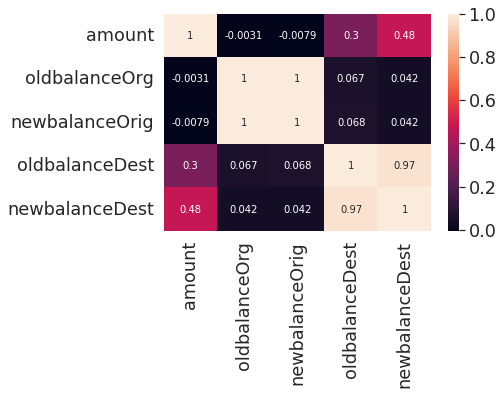

In [18]:
cont_var = dataset[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
corrMatrix = cont_var.corr()
sns.heatmap(corrMatrix, annot=True,annot_kws={"size": 10})
plt.show()

In [ ]:
dataset.describe(include= 'object')

,type,nameOrig,nameDest,isFraud,isFlaggedFraud
count,260921,260921,260921,260921,260921
unique,2,260909,175662,2,2
top,CASH_OUT,C1795024002,C302740522,0,0
freq,210764,2,11,260123,260917


Text(0.5, 1.0, 'isFraud')

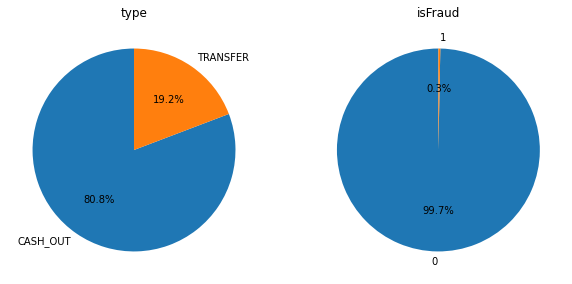

In [ ]:
counts_type = dataset.type.value_counts().to_frame()
counts_type['Percentage'] = counts_type['type']/counts_type['type'].sum()
counts_fraud = dataset.isFraud.value_counts().to_frame()
counts_fraud['Percentage'] = counts_fraud['isFraud']/counts_fraud['isFraud'].sum()

fig, ax1 = plt.subplots(1, 2, figsize=(10,5))
ax1[0].pie(counts_type['Percentage'], labels=counts_type.index, autopct='%1.1f%%', startangle=90)
ax1[0].set_title('type')
ax1[1].pie(counts_fraud['Percentage'], labels=counts_fraud.index, autopct='%1.1f%%', startangle=90)
ax1[1].set_title('isFraud')


In [ ]:
dataset[(dataset['type'] == 'TRANSFER') & (dataset['isFraud'] == 0)]['amount'].mean()

912248.3018374349

In [ ]:
dataset_f[dataset_f['type'] == 'TRANSFER']['amount'].mean()

1411587.9881122448

In [ ]:
dataset[(dataset['type'] == 'CASH_OUT') & (dataset['isFraud'] == 0)]['amount'].mean()

174497.64874903802

In [ ]:
dataset_f[dataset_f['type'] == 'CASH_OUT']['amount'].mean()

1432842.48140394

In [ ]:
dataset_f

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
160,656,TRANSFER,9468064.05000,C554608123,9468064.05000,0.00000,C532377290,0.00000,0.00000,1,0
1591,703,CASH_OUT,337287.72000,C976181773,337287.72000,0.00000,C497482843,32681.26000,369968.98000,1,0
3317,652,CASH_OUT,258570.41000,C205274654,258570.41000,0.00000,C1586846066,0.00000,258570.41000,1,0
3389,146,CASH_OUT,322329.78000,C2110396645,322329.78000,0.00000,C842496101,115917.67000,438247.45000,1,0
3836,656,TRANSFER,46291.81000,C1608445918,46291.81000,0.00000,C797035468,0.00000,0.00000,1,0
...,...,...,...,...,...,...,...,...,...,...,...
594216,242,TRANSFER,509985.31000,C973074458,509985.31000,0.00000,C1408872887,0.00000,0.00000,1,0
595288,537,TRANSFER,34238.20000,C1437366708,34238.20000,0.00000,C913630133,0.00000,0.00000,1,0
597067,226,CASH_OUT,1231309.64000,C488263608,1231309.64000,0.00000,C168611895,27650.97000,1258960.61000,1,0
598380,212,TRANSFER,10000000.00000,C217654973,24953893.08000,14953893.08000,C167868594,0.00000,0.00000,1,0


## **4 - Data Preparation**
### 4.1 - Selecting Features

In [ ]:
dataset_2 = dataset.drop(['step','nameOrig','nameDest','isFlaggedFraud'], axis=1)

### 4.2 - Encoding Features

In [ ]:
enc = OneHotEncoder(cols=['type'], use_cat_names=True)
dataset_2 = enc.fit_transform(dataset_2)

In [ ]:
dataset_2.head()

,type_CASH_OUT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,0,57384.49000,104661.00000,47276.51000,153452.69000,210837.18000,0
6,1,0,1491.37000,0.00000,0.00000,531174.18000,532665.55000,0
7,1,0,90446.25000,40685.00000,0.00000,69249.07000,159695.32000,0
8,1,0,158392.49000,40716.00000,0.00000,122443.32000,280835.81000,0
9,0,1,1563250.33000,0.00000,0.00000,2877593.48000,4440843.81000,0


In [ ]:
for col in ['type_CASH_OUT','type_TRANSFER','isFraud']:
    dataset_2[col] = dataset_2[col].astype('category')

In [ ]:
X = dataset_2.drop(["isFraud"], axis=1)
y = dataset_2[["isFraud"]].values.ravel()

## **5 - Machine Learning Modeling**
### 5.1 - Cross validation


In [ ]:
names = ['NaiveBayes', 'Logistic Regression','Random Forest', 'LGBM']
models = DummyClassifier(), GaussianNB(), LogisticRegression(), RandomForestClassifier(), LGBMClassifier()
X = dataset_2.drop(["isFraud"], axis=1)
y = dataset_2[["isFraud"]]

metrics_final = pd.DataFrame()

for n in range(0,len(models)):
  print(names[n])
  metrics = ml_cv_results(names[n], models[n], X, y)
  metrics_final = metrics_final.append(metrics)
  metrics_final.to_csv(r"/content/drive/MyDrive/github/fraud_detection/metrics/cv_fraud_1.csv", index = True, header=True)
  


In [ ]:
names = ['KNN','SVM','MLP']
models = KNeighborsClassifier(), SVC(), MLPClassifier()

X = dataset_2.drop(["isFraud"], axis=1)
y = dataset_2[["isFraud"]]

metrics_final = pd.DataFrame()

for n in range(0,len(models)):
  print(names[n])
  metrics = ml_cv_results(names[n], models[n], X, y)
  metrics_final = metrics_final.append(metrics)
  metrics_final.to_csv(r"/content/drive/MyDrive/github/fraud_detection/metrics/cv_fraud_2.csv", index = True, header=True)
  

In [ ]:
models = [XGBClassifier()]
names = ['XGB']
X = dataset_2.drop(["isFraud"], axis=1)
X['type_CASH_OUT'] =  pd.to_numeric(X['type_CASH_OUT'])
X['type_TRANSFER'] =  pd.to_numeric(X['type_TRANSFER'])

y = dataset_2[["isFraud"]]

metrics_final = pd.DataFrame()

for n in range(0,len(models)):
  print(names[n])
  metrics = ml_cv_results(names[n], models[n], X, y)
  metrics_final = metrics_final.append(metrics)
  metrics_final.to_csv(r"/content/drive/MyDrive/github/fraud_detection/metrics/cv_fraud_3.csv", index = True, header=True)

### 5.2 - Model comparison

In [ ]:
files = os.listdir("/content/drive/MyDrive/github/fraud_detection/metrics/")
os.chdir("/content/drive/MyDrive/github/fraud_detection/metrics/")
metrics_final = pd.DataFrame()

for file in files: 
  metrics = pd.read_csv(file,index_col='Unnamed: 0', encoding='utf8', engine='python')
  metrics_final = metrics_final.append(metrics)
metrics_final.sort_values('F1')

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression scaled,0.513 +/- 0.014,0.933 +/- 0.133,0.025 +/- 0.028,0.047 +/- 0.052,0.047 +/- 0.052
NaiveBayes,0.693 +/- 0.012,0.078 +/- 0.01,0.4 +/- 0.023,0.131 +/- 0.015,0.126 +/- 0.015
SVM scaled,0.536 +/- 0.011,1.0 +/- 0.0,0.071 +/- 0.023,0.132 +/- 0.039,0.132 +/- 0.039
NaiveBayes scaled,0.698 +/- 0.011,0.082 +/- 0.01,0.411 +/- 0.021,0.137 +/- 0.015,0.132 +/- 0.015
LGBM scaled,0.691 +/- 0.1,0.275 +/- 0.2,0.386 +/- 0.201,0.309 +/- 0.197,0.306 +/- 0.198
LGBM,0.696 +/- 0.12,0.308 +/- 0.211,0.395 +/- 0.239,0.332 +/- 0.221,0.33 +/- 0.222
SVM,0.621 +/- 0.012,0.995 +/- 0.01,0.242 +/- 0.024,0.389 +/- 0.031,0.388 +/- 0.031
MLP scaled,0.694 +/- 0.019,0.913 +/- 0.051,0.387 +/- 0.037,0.543 +/- 0.044,0.543 +/- 0.044
Logistic Regression,0.847 +/- 0.021,0.485 +/- 0.019,0.696 +/- 0.042,0.57 +/- 0.01,0.569 +/- 0.01
MLP,0.903 +/- 0.065,0.529 +/- 0.23,0.81 +/- 0.133,0.584 +/- 0.147,0.582 +/- 0.148


### 5.3 - Hyperparameter Tuning

In [ ]:
scoring = make_scorer(f1_score)
param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 1, 3, 5],
}

In [ ]:
y = dataset_2[["isFraud"]].values.ravel()

gs = GridSearchCV(RandomForestClassifier(), 
                  param_grid = param_grid, 
                  scoring = scoring, 
                  cv=StratifiedKFold(n_splits=5))

gs.fit(X, y)

In [ ]:
# saving results
gs_rf = open("/content/drive/MyDrive/Projetos_ML/fraud/metrics/new/gs_rf.pkl", "wb")
pickle.dump(gs, gs_rf)
gs_rf.close()

In [ ]:
gs = pickle.load(open('/content/drive/MyDrive/Projetos_ML/fraud/metrics/new/gs_rf.pkl', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or i

In [ ]:
gs.cv_results_['params']

[{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100},
 {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 150},
 {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 200},
 {'criterion': 'gini', 'max_features': 1, 'n_estimators': 100},
 {'criterion': 'gini', 'max_features': 1, 'n_estimators': 150},
 {'criterion': 'gini', 'max_features': 1, 'n_estimators': 200},
 {'criterion': 'gini', 'max_features': 3, 'n_estimators': 100},
 {'criterion': 'gini', 'max_features': 3, 'n_estimators': 150},
 {'criterion': 'gini', 'max_features': 3, 'n_estimators': 200},
 {'criterion': 'gini', 'max_features': 5, 'n_estimators': 100},
 {'criterion': 'gini', 'max_features': 5, 'n_estimators': 150},
 {'criterion': 'gini', 'max_features': 5, 'n_estimators': 200},
 {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100},
 {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 150},
 {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 200},
 

In [ ]:
gs.cv_results_['mean_test_score']

array([0.83738038, 0.83874008, 0.83831728, 0.83353817, 0.82995022,
       0.8321947 , 0.83852463, 0.83419535, 0.83582456, 0.8383731 ,
       0.83988507, 0.83895354, 0.83879945, 0.8380146 , 0.84015864,
       0.82644088, 0.83014593, 0.82918023, 0.83829803, 0.83827056,
       0.83770769, 0.84522141, 0.84416423, 0.84363961])

In [ ]:
gs.cv_results_['mean_fit_time']

array([ 58.39027472,  84.92784719, 114.28137746,  46.17104607,
        67.86613145,  92.5402432 ,  68.83981504, 102.72401714,
       156.55050063, 113.58210468, 149.43353262, 170.47393866,
        54.33963723,  78.03241758, 105.21842108,  33.88933277,
        50.42112775,  68.22461843,  66.8173974 , 107.36116238,
       130.97968202,  86.13192153, 148.00628114, 178.59807291])

In [ ]:
gs.best_params_

{'criterion': 'entropy', 'max_features': 5, 'n_estimators': 100}

### 5.4 - Results
Since the hyperparameter tuning showed very similar results, the default config will be maintened  

### 5.4.1 - One time result

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test))

Text(0.5, 15.0, 'Predicted')

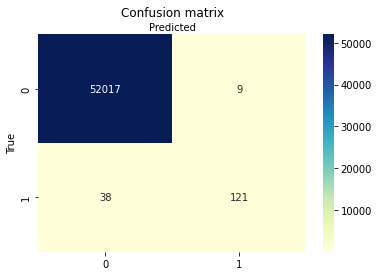

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

In [ ]:
 model1 = pd.DataFrame({"Balanced Accuracy": balanced_accuracy_score(y_test, y_pred),
                        "Precision": precision_score(y_test, y_pred),
                        "Recall": recall_score(y_test, y_pred),
                        "F1": f1_score(y_test, y_pred),
                        "Kappa": cohen_kappa_score(y_test, y_pred)},
                       index=["RandomForest"])
model1

,Balanced Accuracy,Precision,Recall,F1,Kappa
RandomForest,0.88042,0.93077,0.76101,0.83737,0.83692


### 5.4.2 - Cross validation

In [ ]:
metrics_final.iloc[12:13,0]

Random Forest    0.865 +/- 0.013
Name: Balanced Accuracy, dtype: object

## **6 - Company Expansion Strategy**



In [ ]:
data_test = X_test
data_test.reset_index(drop=True, inplace=True)
data_test['Fraud'] = y_test
data_test['Prediction'] = y_pred

### 6.1 - The company will receive 25% of the value of each transaction that is truly detected as fraud.

In [ ]:
aux1 = data_test[(data_test['Fraud'] == 1) & (data_test['Prediction'] == 1)]
receives = aux1['amount'].sum() * 0.25

print('The company would receive %.0f for the correct detection of fraudulent transactions.' % (receives))

The company would receive 63252552 for the correct detection of fraudulent transactions.


### 6.2 - The company will receive 5% of the value of each transaction detected as fraud, however the transaction is truly legitimate.

In [ ]:
aux1 = data_test[(data_test['Fraud'] == 0) & (data_test['Prediction'] == 1)]
receives = aux1['amount'].sum() * 0.05

print('The company would receive %.0f for the false detection of fraudulent transactions.' % (receives))

The company would receive 363418 for the false detection of fraudulent transactions.


### 6.3 - The company will return 100% of the value to the customer for each transaction detected as legitimate, however the transaction is truly a fraud.

In [ ]:
aux1 = data_test[(data_test['Fraud'] == 1) & (data_test['Prediction'] == 0)]
receives = aux1['amount'].sum()

print('The company would return %.0f for the miss detection of fraud transactions.' % (receives))

The company would return 6355497 for the miss detection of fraud transactions.


## **7 - Report Results**
### 7.1 - What is the model's Precision and Accuracy?

In [ ]:
print('The 5-fold cross-validation of the model showed a balanced accuracy of %s and a precision of %s.' % (str(metrics_final.iloc[12]['Balanced Accuracy']), str(metrics_final.iloc[12]['Precision'])))




The 5-fold cross-validation of the model showed a balanced accuracy of 0.865 +/- 0.013 and a precision of 0.961 +/- 0.021.


### 7.2 - How Reliable is the model in classifying transactions as legitimate or fraudulent?

In [ ]:
print('The model showed a F1 score of %s' % (str(metrics_final.iloc[12]['F1'])))


The model showed a F1 score of 0.829 +/- 0.017


### 7.3 - What is the Expected Revenue by the Company if we classify 100% of transactions with the model?

In [ ]:
aux1 = data_test[(data_test['Fraud'] == 1) & (data_test['Prediction'] == 1)]
receives1 = aux1['amount'].sum() * 0.25

aux2 = data_test[(data_test['Fraud'] == 0) & (data_test['Prediction'] == 1)]
receives2 = aux2['amount'].sum() * 0.05

print('Using the model the company can revenue %.0f.' % (receives1 + receives2))

Using the model the company can revenue 63615970.


### 7.4 - What is the Loss Expected by the Company in case of model failure?

In [ ]:
aux1 = data_test[(data_test['Fraud'] == 1) & (data_test['Prediction'] == 0)]
losses = aux1['amount'].sum()

print('The company would return %.0f for the miss detection of fraud transactions.' % (losses))

The company would return 6355497 for the miss detection of fraud transactions.


###7.5 - What is the Profit Expected by the Blocker Fraud Company when using the model?

In [ ]:
print('Using the model the company can revenue %.0f.' % (receives1 + receives2 - losses))

Using the model the company can revenue 57260473.


## **6 - Model Deploy**
### 6.1 - Saving model and encoder

In [ ]:
pickle.dump( model, open('/content/drive/My Drive/github/fraud_detection/models/model_rf_fraud.pkl','wb'))

In [ ]:
dataset = dataset.drop(['step','nameOrig','nameDest','isFlaggedFraud','isFraud'], axis=1)

enc = OneHotEncoder(cols=['type'], use_cat_names=True)
model_enc = enc.fit(dataset)

pickle.dump( model_enc, open('/content/drive/My Drive/github/fraud_detection/models/enc_fraud.pkl','wb'))

### 6.2 - API Handler


In [ ]:
!pip install flask-ngrok
!pip install category_encoders

In [ ]:
import pandas as pd
import pickle
import json
from flask import Flask, request, Response
from flask_ngrok import run_with_ngrok
from category_encoders       import OneHotEncoder

In [ ]:
class Fraud: 
    def __init__(self):
        self.encoder = pickle.load(open('/content/drive/My Drive/github/fraud_detection/models/enc_fraud.pkl', 'rb'))
              
    def data_preparation(self, data_set):
        # selected columns
        final_columns = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
        data_set2 = data_set[final_columns]

        # OneHotEncoder
        data_set3 = self.encoder.transform(data_set2)
        for col in ['type_CASH_OUT','type_TRANSFER']:
            data_set3[col] = data_set3[col].astype('category')       
              
        return data_set3
    
    def get_prediction(self, model, original_data, test_data):
        pred = model.predict(test_data)
        original_data['prediction'] = pred
        
        return original_data.to_json()

In [ ]:
# load model
model = pickle.load(open('/content/drive/My Drive/github/fraud_detection/models/model_rf_fraud.pkl', 'rb'))
# instanciate flask
app = Flask( __name__ )
run_with_ngrok(app)

@app.route('/predict', methods=['POST'])  
def predict():
    ori_json = request.get_json()

    # collect data
    if ori_json:
      #aux_json = json.loads(ori_json)
      df_raw = pd.DataFrame.from_dict(ori_json, orient="columns")
      # Instantiate Fraud class
      pipeline = Fraud()

      # data prepatarion
      df = pipeline.data_preparation(df_raw)

      # prediction
      pred = pipeline.get_prediction(model, df_raw, df)
    
      return Response(pred, mimetype='application/json')
    else:
      return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
  app.run()

### 6.2 - Testing the API

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/github/fraud_detection/data/reduced_data.csv")
dataset = dataset.loc[(dataset['type'] == "CASH_OUT") | (dataset['type'] == "TRANSFER")]
dataset_f = dataset[dataset['isFraud'] == 1]

In [ ]:
df_r = dataset.iloc[5300:5305,:]
df_f = dataset_f.iloc[50:55,:]

df_s = df_r.append(df_f)

df_s_json = df_s.to_json()

In [ ]:
url = 'http://94f6-34-80-11-116.ngrok.io/predict'
data = df_s_json
header = {'Content-type': 'application/json'}

#request
re = requests.post(url=url, data=data, headers=header)
re

<Response [200]>

In [ ]:
df_pred= pd.DataFrame.from_dict(re.json(), orient="columns")
df_pred

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,prediction
12144,273,CASH_OUT,294983.53,C1565139458,50031.00,0.00,C1792922740,34789.58,329773.10,0,0,0
12147,40,CASH_OUT,222193.67,C1874842756,23245.00,0.00,C2130510859,4834186.09,5056379.76,0,0,0
12148,396,CASH_OUT,266680.39,C988610840,53722.00,0.00,C1911412643,235758.15,502438.54,0,0,0
12150,683,CASH_OUT,286519.64,C310794561,59278.00,0.00,C496458544,131340.63,417860.27,0,0,0
12153,138,TRANSFER,444302.27,C2140056879,30458.00,0.00,C1466019611,0.00,436171.38,0,0,0
42394,160,TRANSFER,7670038.08,C1744142327,7670038.08,0.00,C197131659,0.00,0.00,1,0,1
44432,249,TRANSFER,10000000.00,C2071602509,11306690.61,1306690.61,C39886288,0.00,0.00,1,0,1
44690,429,TRANSFER,837192.23,C653262851,837192.23,0.00,C690345380,0.00,0.00,1,0,1
44951,603,TRANSFER,4099382.36,C371063342,4099382.36,0.00,C1426227397,0.00,0.00,1,0,1
46535,266,CASH_OUT,3486005.08,C1300574911,3486005.08,0.00,C952807483,50634.59,3536639.67,1,0,1
